In [12]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
import os
import numpy as np

In [5]:
with open('jena_data_float.npy', 'rb') as f:
    float_data = np.load(f)
    
print(float_data.shape)

(420451, 14)


In [6]:
def generator(data, lookback, delay, min_ix, max_ix, shuffle=False, batch_size=128, step=6):
    if max_ix is None:
        max_ix = len(data)-delay-1
    
    i = min_ix + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_ix+lookback, max_ix, size=batch_size)
        else:
            if i+batch_size >= max_ix:
                i = min_ix + lookback
            
            rows = np.arange(i, min(i+batch_size, max_ix))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j],step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=0,
                      max_ix=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=200001,
                      max_ix=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_ix=300001,
                      max_ix=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000-200001-lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                    epochs=10, validation_data=val_gen, validation_steps=500)

Epoch 1/10
500/500 [==============================] - 8s 14ms/step - loss: 0.3335 - val_loss: 0.2687
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2871 - val_loss: 0.2662
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2806 - val_loss: 0.2656
Epoch 4/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2775 - val_loss: 0.2660
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2696 - val_loss: 0.2653
Epoch 6/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2678 - val_loss: 0.2793
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2640 - val_loss: 0.2677
Epoch 8/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2595 - val_loss: 0.2677
Epoch 9/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2560 - val_loss: 0.2754
Epoch 10/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2529 - val_lo

In [19]:
model.save('temp_gru_baseline.h5')

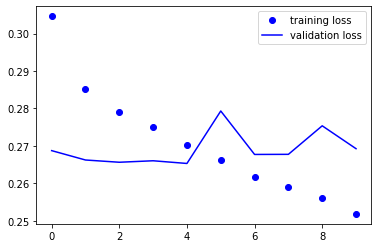

In [20]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

In [17]:
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 6ms/step - loss: 0.2835


0.28345561027526855

In [21]:
# more training - more steps
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 7ms/step - loss: 0.2862


0.28615111112594604

In [24]:
"""
dropout
recurrent_dropout
"""
model = Sequential()
model.add(layers.GRU(32, dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=50,
                    epochs=10, validation_data=val_gen, validation_steps=50)


Epoch 1/10
50/50 [==============================] - 16s 292ms/step - loss: 0.5433 - val_loss: 0.3043
Epoch 2/10
50/50 [==============================] - 14s 286ms/step - loss: 0.3341 - val_loss: 0.2972
Epoch 3/10
50/50 [==============================] - 15s 293ms/step - loss: 0.3319 - val_loss: 0.2802
Epoch 4/10
50/50 [==============================] - 14s 288ms/step - loss: 0.3177 - val_loss: 0.2893
Epoch 5/10
50/50 [==============================] - 14s 286ms/step - loss: 0.3264 - val_loss: 0.2903
Epoch 6/10
50/50 [==============================] - 14s 287ms/step - loss: 0.3130 - val_loss: 0.2786
Epoch 7/10
50/50 [==============================] - 14s 287ms/step - loss: 0.3097 - val_loss: 0.2782
Epoch 8/10
50/50 [==============================] - 14s 285ms/step - loss: 0.3108 - val_loss: 0.2767
Epoch 9/10
50/50 [==============================] - 14s 286ms/step - loss: 0.3071 - val_loss: 0.2746
Epoch 10/10
50/50 [==============================] - 14s 286ms/step - loss: 0.3139 - val_lo

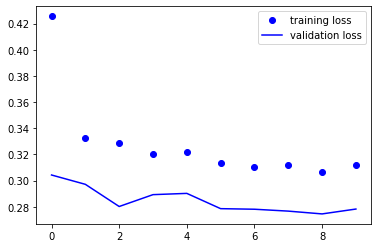

In [25]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

```
regularization displayed the effect and didnt even let the model to train, forget about overfitting.

The validation scores are bad, but training are much worse.

Just the scale is changed and looks good, but isnt
```


In [26]:
model.save('temp_gru_dropouts.h5')

In [27]:
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 3s 32ms/step - loss: 0.2989


0.29893654584884644

## Stacking Multiple layers

In [36]:
"""
its not overfitting, maybe bottleneck is there
so lets add more layers
"""
model = Sequential()
model.add(layers.GRU(32, dropout=0.5,
                     activation='tanh',
                     recurrent_dropout=0,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='tanh',
                     dropout=0.5,
                     recurrent_dropout=0))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=200,
                    epochs=10, validation_data=val_gen, validation_steps=100)


Epoch 1/10
200/200 [==============================] - 6s 23ms/step - loss: 0.4031 - val_loss: 0.2986
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3460 - val_loss: 0.3033
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3331 - val_loss: 0.2852
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3245 - val_loss: 0.2971
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3187 - val_loss: 0.2968
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3150 - val_loss: 0.3040
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3092 - val_loss: 0.2784
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3093 - val_loss: 0.2979
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3055 - val_loss: 0.2843
Epoch 10/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3041 - val_lo

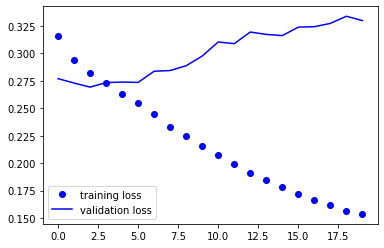

In [33]:
# trained with more steps - 20 epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

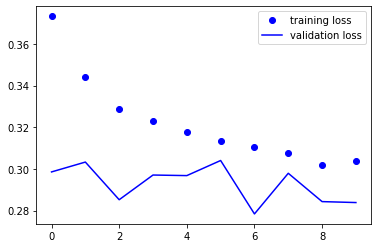

In [37]:
# trained with less steps - 10 epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

In [34]:
model.save('temp_gru_stacked.h5')

In [35]:
# 20 epoch
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 8ms/step - loss: 0.3394


0.33937063813209534

In [39]:
# 10 epoch
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 8ms/step - loss: 0.2937


0.2936895489692688

## BiDirectional GRU

All predictive capacity must come from chronological half of the network, because the anti-chronological half is known to be severly underperforming on this task.

### Recent Past Matters Much More than the Distant Past

In [40]:
"""
BiDirectional GRU
"""
model = Sequential()

model.add(layers.Bidirectional(
    layers.GRU(32), 
    input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen, steps_per_epoch=200,
                    epochs=10, validation_data=val_gen, validation_steps=100)

Epoch 1/10
200/200 [==============================] - 6s 20ms/step - loss: 0.3444 - val_loss: 0.2745
Epoch 2/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2900 - val_loss: 0.2808
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2820 - val_loss: 0.2725
Epoch 4/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2791 - val_loss: 0.2664
Epoch 5/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2746 - val_loss: 0.2656
Epoch 6/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2705 - val_loss: 0.2689
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2662 - val_loss: 0.2697
Epoch 8/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2670 - val_loss: 0.2651
Epoch 9/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2614 - val_loss: 0.2738
Epoch 10/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2613 - val_lo

In [41]:
model.save('temp_bidirectional_gru.h5')

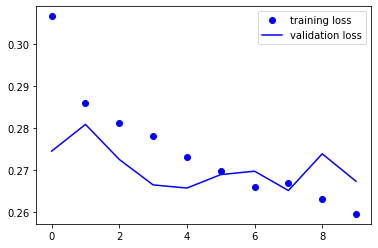

In [42]:
# trained with less steps - 10 epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

In [43]:
model.evaluate(test_gen, steps=100)

100/100 [==============================] - 1s 8ms/step - loss: 0.2846


0.2845936715602875